# Time Series Model for Australian Total Wine Sales Using Python
### David Lowe
### September 11, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Australian Total Wine Sales dataset is a time series situation where we are trying to forecast future outcomes based on past data points.

INTRODUCTION: The problem is to forecast monthly wine sales in Australia. The dataset describes a time-series of wine sales by Australian winemakers between Jan 1980 – Aug 1994, and there are 176 observations. We used the first 75% of the observations for training and testing various models, while holding back the last 25% of the observations for validating the final model.

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 7532. After performing a grid search for the most optimal ARIMA parameters, the final ARIMA non-seasonal order was (1, 1, 2) with the seasonal order being (0, 1, 1, 12). Furthermore, the chosen model processed the validation data with an RMSE of 2907, which was better than the baseline model as expected.

CONCLUSION: For this dataset, the chosen ARIMA model achieved a satisfactory result and should be considered for further modeling.

Dataset Used: Monthly Australian Total Wine Sales

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.datasets.load_wineind.html

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib
import warnings
import pmdarima as pm
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### 1.b) Set up the controlling parameters and functions

In [2]:
# Create the random seed number for reproducible results
seedNum = 888

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

In [3]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [4]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

Since the dataset is not current, this means that we cannot easily collect updated data to validate the model. Therefore, we will withhold a portion of the data towards the end from analysis and model selection. This very segment of data will be used to validate the final model.

In [5]:
startTimeScript = datetime.now()

In [6]:
# load the dataset and the necessary data structure
data_array = pm.datasets.load_wineind(as_series=False)
dt_index = pd.date_range('1980-01', periods=len(data_array), freq='M')
target_col = 'Wine'
time_series = pd.DataFrame(data=data_array, index=dt_index, columns=[target_col])
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

# Back up the dataframe to a CSV file
dest_file = 'australian-wine-sales.csv'
if (os.path.isfile(dest_file) == False) :
    time_series.to_csv(dest_file)

The target column of the time series is: Wine
The forecast boundary columns are: lower Wine & upper Wine


In [7]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 1980-01-31 to 1994-08-31
Freq: M
Data columns (total 1 columns):
Wine    176 non-null int64
dtypes: int64(1)
memory usage: 2.8 KB


In [8]:
time_series.head(10)

,Wine
1980-01-31,15136
1980-02-29,16733
1980-03-31,20016
1980-04-30,17708
1980-05-31,18019
1980-06-30,19227
1980-07-31,22893
1980-08-31,23739
1980-09-30,21133
1980-10-31,22591


In [9]:
time_series.tail(10)

,Wine
1993-11-30,32857
1993-12-31,37198
1994-01-31,13652
1994-02-28,22784
1994-03-31,23565
1994-04-30,26323
1994-05-31,23779
1994-06-30,27549
1994-07-31,29660
1994-08-31,23356


In [10]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [11]:
if (notifyStatus): email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [12]:
# Summary statistics of time series
print(time_series.describe())

               Wine
count    176.000000
mean   25392.147727
std     5340.821889
min    13652.000000
25%    22114.750000
50%    24669.000000
75%    28460.750000
max    40226.000000


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:

* Whether the trend appears to be level around the mean
* Whether there appear to be any obvious outliers

The ARIMA(p,d,q) model requires three parameters and assumes that we are working with a stationary time series.

The ADF results should show that the test statistic value is smaller than the critical value at 5% if the time series is stationary. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

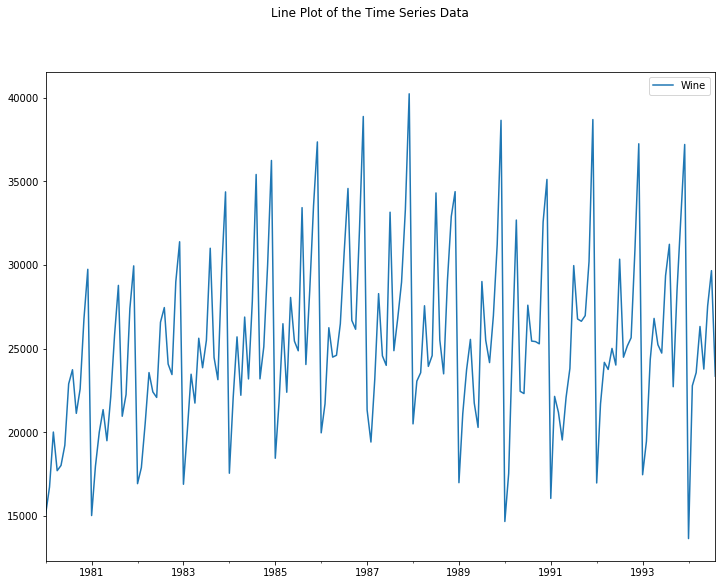

In [13]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) ACF and PACF Plots of the Time Series Data

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can get some good ideas by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

In [14]:
# Check if stationary
result = adfuller(time_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.852468
p-value: 0.051161
Critical Test Statistics Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576


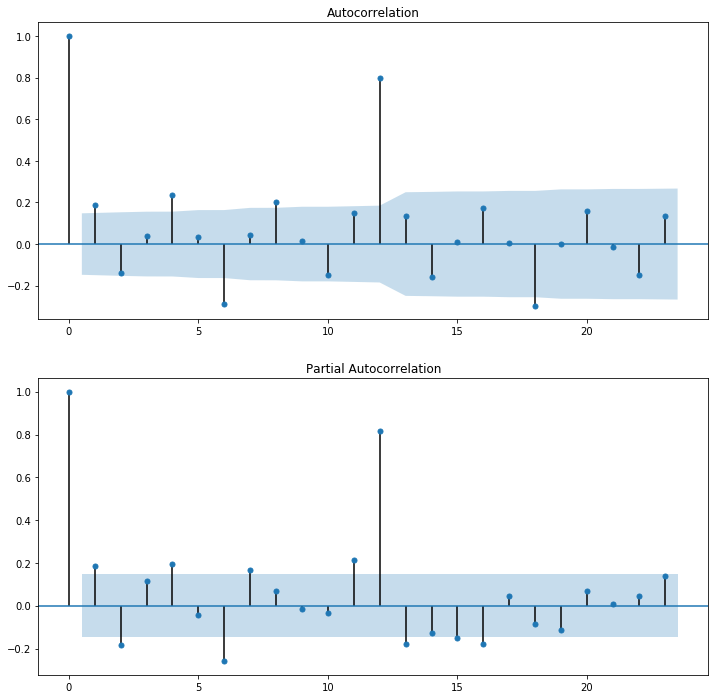

In [15]:
# ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(time_series, ax=ax1)
plot_pacf(time_series, ax=ax2)
plt.show()

### 2.d) Histogram and Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots can include:

* Whether the distribution is Gaussian
* Whether the distribution has a long tail and may suggest the need for data transformation

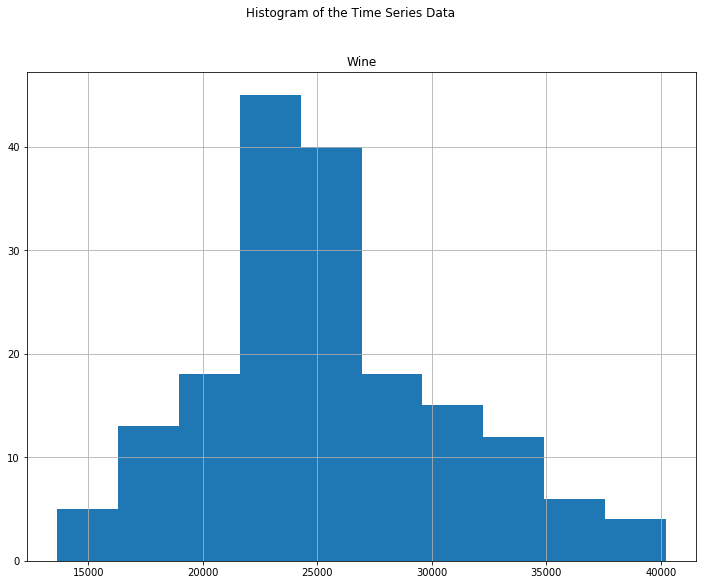

In [16]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

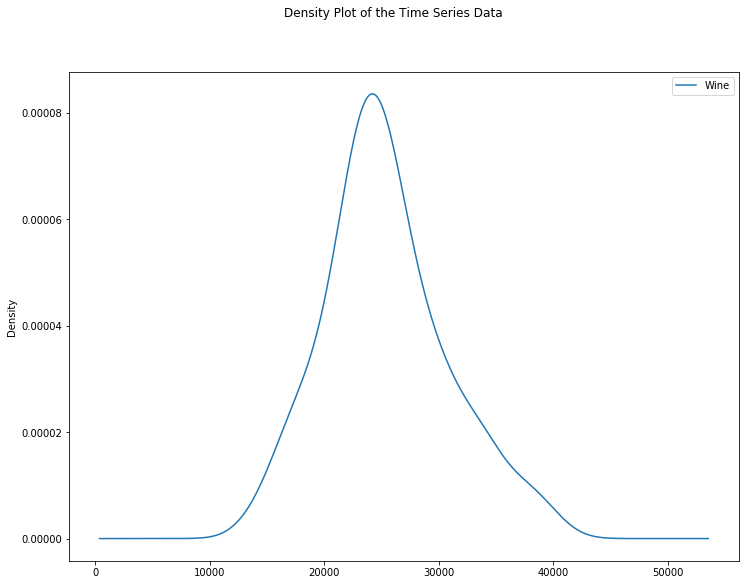

In [17]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.e) Box and Whisker Plots of the Time Series Data

We can group or aggregate the data and get a better idea of the spread of observations. Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend
* Whether the spread, or middle 50% of the data, shows any significant variability
* Whether there are outliers in some grouping

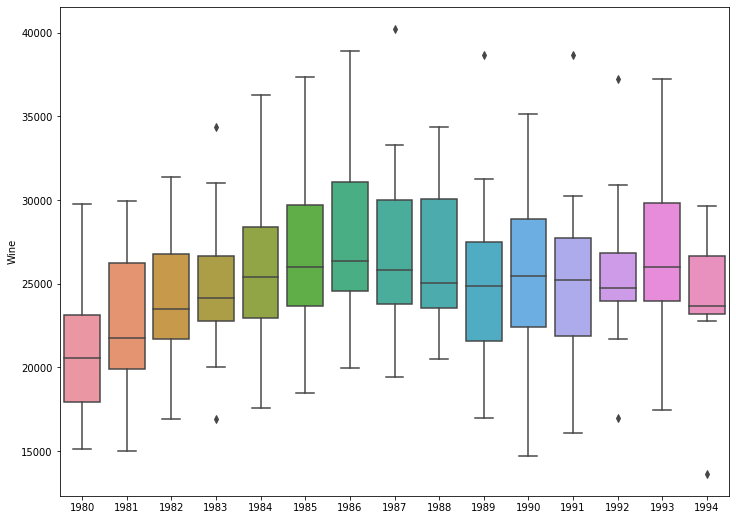

In [18]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(12,9))
squeezed = time_series.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax=ax)
plt.show()

### 2.f) Seasonal Decomposition for Seasonal Time Series Data

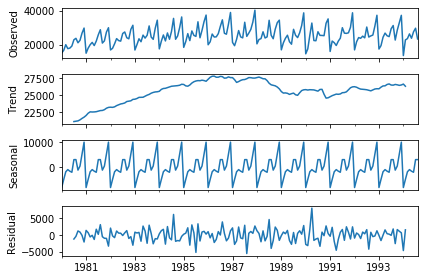

In [19]:
# Perform seasonal decomposition to observe the seasonal frequency
decomp_results = seasonal_decompose(time_series)
decomp_results.plot()
plt.show()

In [20]:
# Detrending the time series
N = 36
detrend = time_series - time_series.rolling(N).mean()
detrend = detrend.dropna()

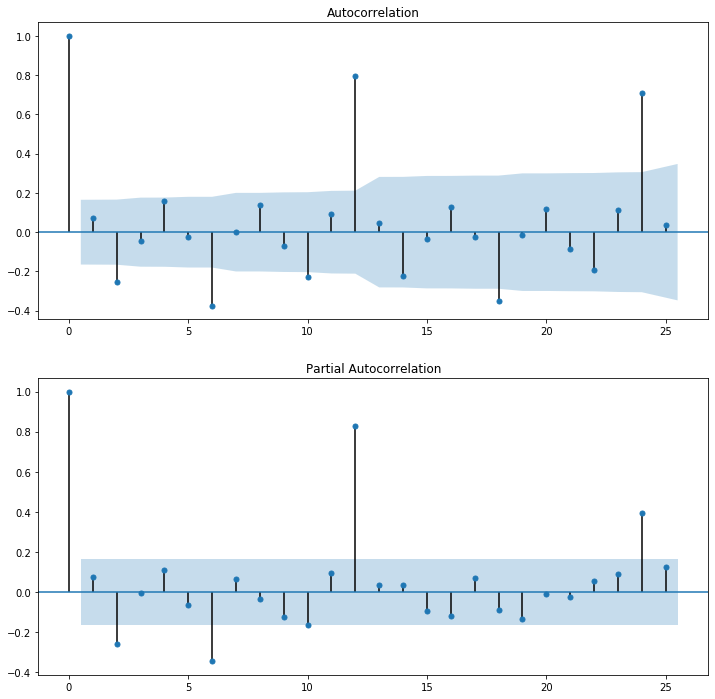

In [21]:
# ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(detrend, lags=25, ax=ax1)
plot_pacf(detrend, lags=25, ax=ax2)
plt.show()

In [22]:
# Set the seasonal frequency parameter for later uses in the script
seasonal_freq = 12

### 2.g) Test for Stationarity of Non-Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

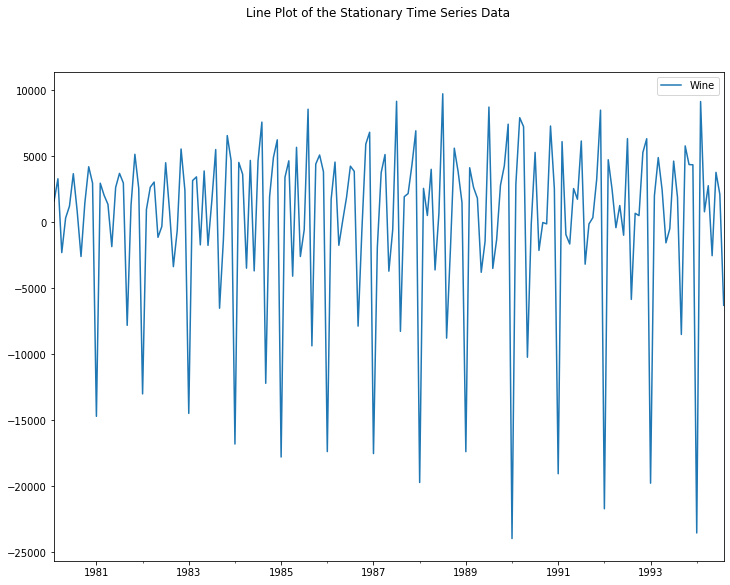

In [23]:
# Create a differenced series
stationary_ns = time_series.diff().dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ns.plot(ax=ax)
plt.show()

In [24]:
# Check for stationarity
result = adfuller(stationary_ns[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -23.414234
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576


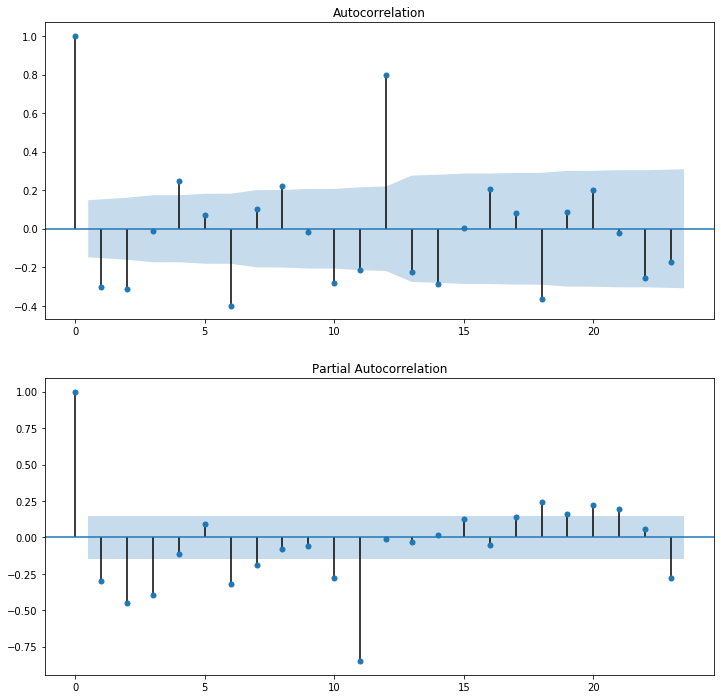

In [25]:
# ACF and PACF plots of the stationary time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ns, ax=ax1)
plot_pacf(stationary_ns, ax=ax2)
plt.show()

In [26]:
# Set the p, d, and q order parameters for later uses in the script
start_p = 0
order_d = 1
start_q = 0
max_p = 5
max_q = 5

### 2.h) Test for Stationarity of Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

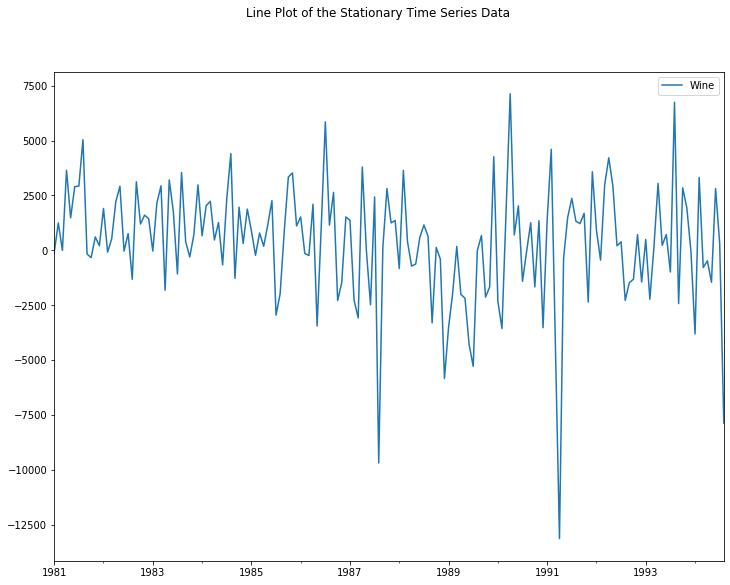

In [27]:
# Create a differenced series
stationary_ss = time_series.diff(seasonal_freq).dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ss.plot(ax=ax)
plt.show()

In [28]:
# Check for stationarity
result = adfuller(stationary_ss[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.622085
p-value: 0.088518
Critical Test Statistics Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


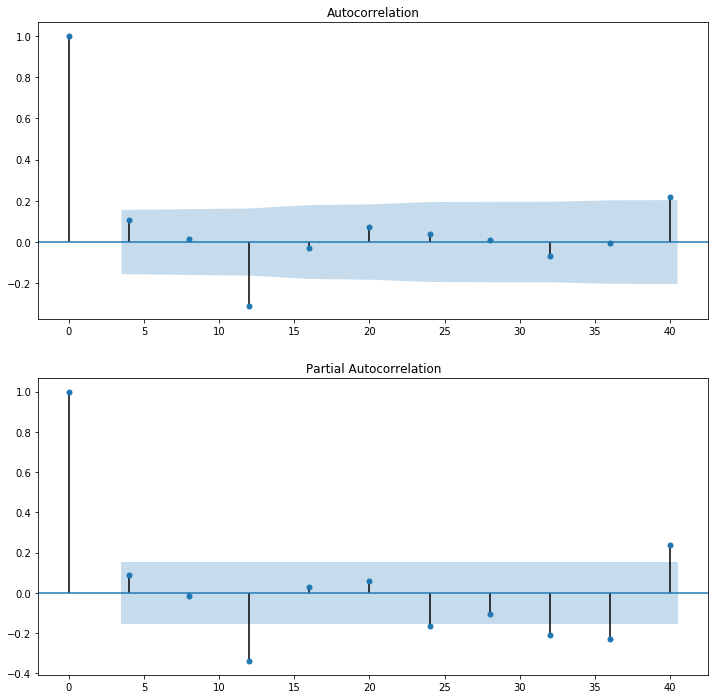

In [29]:
# ACF and PACF plots of the stationary time series
lags = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ss, lags=lags, ax=ax1)
plot_pacf(stationary_ss, lags=lags, ax=ax2)
plt.show()

In [30]:
# Not applicable for this time series dataset
# Set the P, D, and Q order parameters for later uses in the script
start_P = 0
order_D = 1
start_Q = 0
max_P = 5
max_Q = 5

In [31]:
if (notifyStatus): email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Clean and Pre-Process Data

In [32]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

This section currently is not applicable to this iteration of the project.

In [33]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem. We will first establish a persistent model. Next we will use a grid search approach to look for an optimal ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

* Establish the Persistent Model
* Automatically Configure the ARIMA
* Review Residual Errors

In [34]:
if (notifyStatus): email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

#### 4.a.iii) Establish the Persistent Model as Baseline

In [35]:
# Prepare and evaluate a persistence model
X = time_series.values
X = X.astype('float32')
train_pct = 0.75
train_size = int(len(X) * train_pct)
test_size = len(X) - train_size
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Calculate performance
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE for the persistent model is: %.3f' % rmse)

>Predicted=35110.000, Expected=16052
>Predicted=16052.000, Expected=22146
>Predicted=22146.000, Expected=21198
>Predicted=21198.000, Expected=19543
>Predicted=19543.000, Expected=22084
>Predicted=22084.000, Expected=23816
>Predicted=23816.000, Expected=29961
>Predicted=29961.000, Expected=26773
>Predicted=26773.000, Expected=26635
>Predicted=26635.000, Expected=26972
>Predicted=26972.000, Expected=30207
>Predicted=30207.000, Expected=38687
>Predicted=38687.000, Expected=16974
>Predicted=16974.000, Expected=21697
>Predicted=21697.000, Expected=24179
>Predicted=24179.000, Expected=23757
>Predicted=23757.000, Expected=25013
>Predicted=25013.000, Expected=24019
>Predicted=24019.000, Expected=30345
>Predicted=30345.000, Expected=24488
>Predicted=24488.000, Expected=25156
>Predicted=25156.000, Expected=25650
>Predicted=25650.000, Expected=30923
>Predicted=30923.000, Expected=37240
>Predicted=37240.000, Expected=17466
>Predicted=17466.000, Expected=19463
>Predicted=19463.000, Expected=24352
>

### 4.b) Grid Search of ARIMA Hyperparameters

We want to find a model that can do better than the persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

We will also disable the automatic addition of a trend constant from the model by setting the ‘trend‘ argument to ‘nc‘ for no constant when calling fit().

In [36]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Do a grid search ARIMA parameters for a time series
print('The suggested non-seasonal differencing term is:', pm.arima.ndiffs(time_series))
if (seasonal_freq > 0): print('The suggested seasonal differencing term is:', pm.arima.nsdiffs(time_series, m = seasonal_freq))
if (seasonal_freq == 0): results = pm.auto_arima(time_series, d = order_d, start_p = start_p, start_q = start_q, max_p = max_p, max_q = max_q, 
                                                seasonal = False, information_criterion = 'aic', trace = True, error_action = 'ignore', stepwise = True, n_jobs = 1)
else:
    results = pm.auto_arima(time_series, d = order_d, start_p = start_p, start_q = start_q, max_p = max_p, max_q = max_q, 
                            seasonal = True, m = seasonal_freq, D = order_D, start_P = start_P, start_Q = start_Q, 
                            max_P = max_P, max_Q = max_Q, information_criterion = 'aic', trace = True, 
                            error_action = 'ignore', stepwise = True, n_jobs = 1)

The suggested non-seasonal differencing term is: 1
The suggested seasonal differencing term is: 1
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3133.376, BIC=3139.564, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3099.734, BIC=3112.109, Fit time=0.248 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3066.930, BIC=3079.305, Fit time=0.304 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3067.842, BIC=3083.311, Fit time=1.089 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3090.512, BIC=3099.793, Fit time=0.080 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3068.080, BIC=3083.549, Fit time=0.591 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3067.891, BIC=3086.454, Fit time=4.937 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3066.760, BIC=3082.229, Fit time=1.222 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_or

In [38]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -1527.371
Date:                            Mon, 26 Aug 2019   AIC                           3066.742
Time:                                    16:08:00   BIC                           3085.305
Sample:                                         0   HQIC                          3074.278
                                            - 176                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -100.7331     72.197     -1.395      0.163    -242.236      40.770
ar.L1         -0.5123      0.390   

In [39]:
# Set the optimal ARIMA order parameters for later uses in the script
ns_order = (1, 1, 2)
ss_order = (0, 1, 1, 12)

In [40]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Evaluate the Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

                                 Statespace Model Results                                 
Dep. Variable:                               Wine   No. Observations:                  176
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -1527.371
Date:                            Mon, 26 Aug 2019   AIC                           3066.742
Time:                                    16:08:01   BIC                           3085.305
Sample:                                01-31-1980   HQIC                          3074.278
                                     - 08-31-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -100.7331     72.197     -1.395      0.163    -242.236      40.770
ar.L1         -0.5123      0.390   

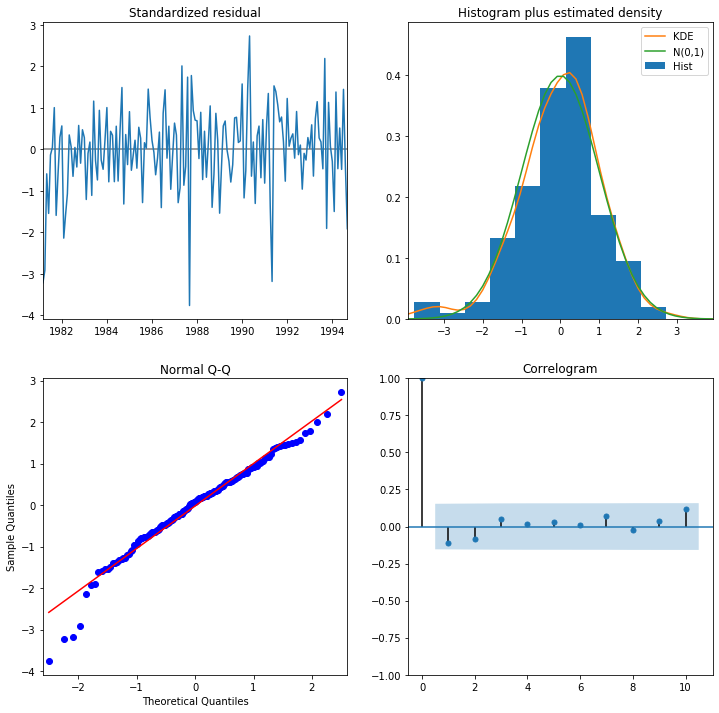

In [41]:
# Summarize residual errors for the chosen ARIMA model
model = SARIMAX(time_series, order=ns_order, seasonal_order=ss_order, trend='c')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(12,12))
plt.show()

In [42]:
if (notifyStatus): email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

In [43]:
if (notifyStatus): email_notify("Model Finalization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Validation via In-sample Data

In [44]:
model = SARIMAX(time_series, order=ns_order, seasonal_order=ss_order, trend='c')
results = model.fit()
forecast = results.get_prediction(start = -test_size)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

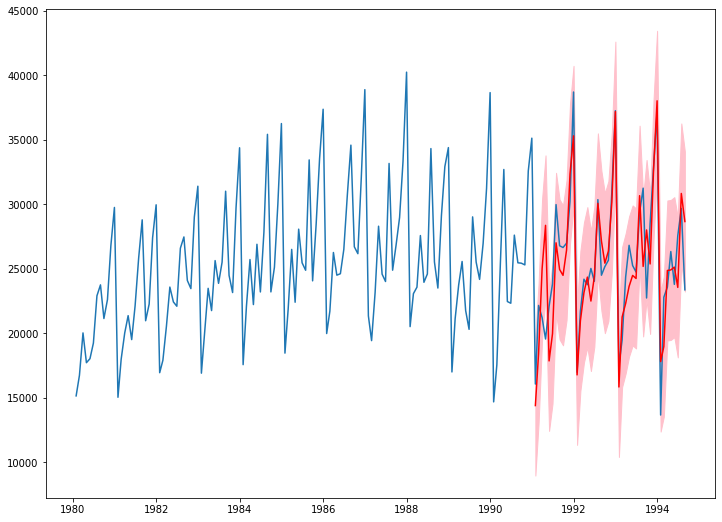

In [45]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals[lower_bound], confidence_intervals[upper_bound], color='pink')
plt.show()

In [46]:
# Evaluate RMSE for the validation data
y = time_series[-test_size:]
predictions = mean_forecast.values
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE from the validation data is: %.3f' % rmse)

RMSE from the validation data is: 2907.767


### 5.b) Forecasting Out-of-Sample Data

In [47]:
forecast = results.get_forecast(steps = test_size)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

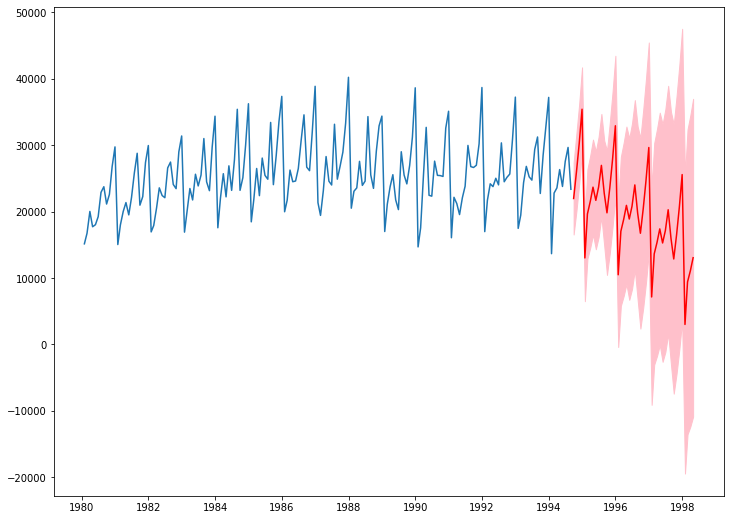

In [48]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals[lower_bound], confidence_intervals[upper_bound], color='pink')
plt.show()

In [49]:
if (notifyStatus): email_notify("Model Finalization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:34.699781
